## Figure 6: 

Cross-section through the warm conveyer belt at day 5.5 for the simulation with CRH. (a) cloud cover, (b) longwave CRH, (c) shortwave CRH, and (d) heating from cloud microphysical processes. Panels (e), (f), and (g) show the associated diabatic PV tendencies.

-----------------------

@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import warnings
warnings.filterwarnings("ignore")
import colorlegend

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


In [3]:
# Dictionary for loading simulations
simdict = {
         'LC1-channel-4000x9000km-2km-0002' : {'res':'2.5km', 'radiation':0, 'rh':0.8, 'mphy':1}, # No radiation 
         'LC1-channel-4000x9000km-2km-0003' : {'res':'2.5km', 'radiation':1, 'rh':0.8, 'mphy':1}, # Cloud radiation 
         }

## 2- Loading datasets

In [8]:
# load temperature tendencies datasets on model levels
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        #print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        # datasets
        fname = path+"icon-ddt_temp*.nc"                                                                     
        ds_var = (xr.open_mfdataset(fname, combine='by_coords',parallel=True))
        # adding cloud-radiative heating rates and total physic tendency
        ds_var['ddt_temp_radsw'] = ds_var['ddt_temp_radswnw'] - ds_var['ddt_temp_radswcs']
        ds_var['ddt_temp_radlw'] = ds_var['ddt_temp_radlwnw'] - ds_var['ddt_temp_radlwcs']
        ds_list.append(ds_var)    
        del ds_var
    return ds_list
#----------------------------------
ds_list_ddt_temp = load_simulations()
#----------------------------------
# load cloud cover datasets on model levels
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        # datasets
        fname = path+"icon-cld3d*.nc"                                                                     
        ds_var = (xr.open_mfdataset(fname, combine='by_coords',parallel=True))
        ds_list.append(ds_var)
        del ds_var
    return ds_list
#----------------------------------
ds_list_cld = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003


In [5]:
# load derived diabatic PV tendencies
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        # datasets
        fname = path+"pv_tendencies.nc"
        ds_var = xr.open_mfdataset(fname)
        ds_list.append(ds_var)
        del ds_var
    return ds_list
#----------------------------------
ds_list = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003


In [9]:
# variables for the cross section plot over the warm conveyer belt

# cloudcover
cs_clc = ds_list_cld[1].clc.sel(time='20210106.5',lon=20+38).compute()
# cloud LW radiative heating rates
cs_cldradlw_hr = ds_list_ddt_temp[1].ddt_temp_radlw.sel(time='20210106.5',lon=20+38).compute()
# cloud LW radiative potential vorticity tendency
cs_cldradlw_pvt = (ds_list[1].ddt_pv_z_radlw.sel(time='20210106.5',lon=20+38)*1e6).compute()
# cloud SW radiative heating rates
cs_cldradsw_hr = ds_list_ddt_temp[1].ddt_temp_radsw.sel(time='20210106.5',lon=20+38).compute()
# cloud SW radiative potential vorticity tendency
cs_cldradsw_pvt = (ds_list[1].ddt_pv_z_radsw.sel(time='20210106.5',lon=20+38)*1e6).compute()
# Microphysical heating rates
cs_gscp_hr = ds_list_ddt_temp[1].ddt_temp_gscp.sel(time='20210106.5',lon=20+38).compute()
# Microphysical PV tendency
cs_gscp_pvt = (ds_list[1].ddt_pv_z_gscp.sel(time='20210106.5',lon=20+38)*1e6).compute()

# 2 PVU contour
pv = (ds_list[1].pv.sel(time='20210106.5',lon=20+38)*1e6).compute()
# sharpening the tropopause 2 PVU contour
pv_new = np.zeros(pv.shape)
pv_new[0:40,:] = pv[0:40,:]

# deriving Vertical profiles of heating rates and PV tendencies accumulated from day 5 to 8
radlw_1 = spin(ds_list_ddt_temp[1].ddt_temp_radlw,20210106,20210109).compute()
radsw_1 = spin(ds_list_ddt_temp[1].ddt_temp_radsw,20210106,20210109).compute()
gscp_1  = spin(ds_list_ddt_temp[1].ddt_temp_gscp,20210106,20210109).compute()
gscp_0  = spin(ds_list_ddt_temp[0].ddt_temp_gscp,20210106,20210109).compute() # REF simulation

# dibatic pv tendencies
pvt_radlw_1 = spin(ds_list[1]['ddt_pv_z_radlw'],20210106,20210109).compute()
pvt_radsw_1 = spin(ds_list[1]['ddt_pv_z_radsw'],20210106,20210109).compute()
pvt_gscp_1  = spin(ds_list[1]['ddt_pv_z_gscp'],20210106,20210109).compute()
pvt_gscp_0  = spin(ds_list[0]['ddt_pv_z_gscp'],20210106,20210109).compute() # REF simulation

## 3- Plot

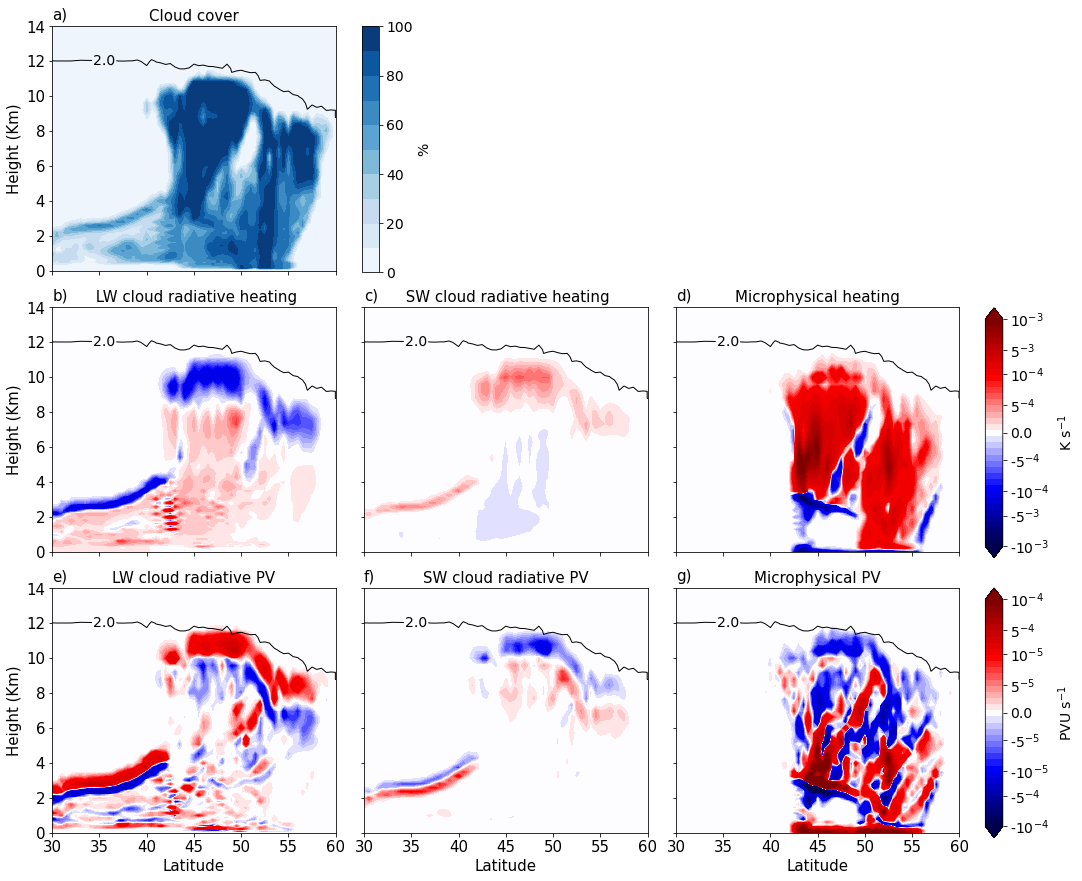

In [117]:
# coordinates for plotting
lev = ds_list[0].z_fl[0,:,50,50].values/1000 # hPa
lat = ds_list[0].lat.values
lon = ds_list[0].lon.values
# location of the label
manual_locations = [(36, 1)]
# defining contour levels
lev1= np.append(np.arange(0.1,1,0.1)*1e-4,np.arange(0.1,1.1,0.1)*1e-3)
lev2= np.append(np.arange(-1,0.0,0.1)*1e-3,np.arange(-0.9,0.0,0.1)*1e-4)
clev_hr = np.append(lev2,lev1)

lev11= np.append(np.arange(0.1,1,0.1)*1e-5,np.arange(0.1,1.1,0.1)*1e-4)
lev22= np.append(np.arange(-1,0.0,0.1)*1e-4,np.arange(-0.9,0.0,0.1)*1e-5)
clev_pv = np.append(lev22,lev11)

#colorbar labels
cbl_lb_hr=['-10$^{-3}$','-5$^{-3}$','-10$^{-4}$','-5$^{-4}$','0.0','5$^{-4}$','10$^{-4}$','5$^{-3}$','10$^{-3}$']
cbl_lb_pv=['-10$^{-4}$','-5$^{-4}$','-10$^{-5}$','-5$^{-5}$','0.0','5$^{-5}$','10$^{-5}$','5$^{-4}$','10$^{-4}$']

# colorbar normalization
cmap = plt.cm.seismic
cmaplist = [cmap(i) for i in np.arange(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

norm_hr = mpl.colors.BoundaryNorm(clev_hr, cmap.N)
norm_pv = mpl.colors.BoundaryNorm(clev_pv, cmap.N)
#------------------------------------------------------------

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))

i = 0

for ax in axes.flat:
    
    ax.tick_params(labelsize=15)
    ax.set_xlim([30, 60])
    ax.set_ylim([0,14])
    ax.spines['left'].set_bounds(0,14)
    ax.set_yticks(np.arange(0,16,2))
    
    if i in [1,2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([]) 
        ax.tick_params(left=False,bottom=False)
    
    if i == 0:
        im0 = ax.contourf(lat,lev,cs_clc,levels=np.arange(0,110,10)
            ,cmap=plt.get_cmap('Blues')) #k/hr
        cs = ax.contour(lat,lev,pv_new,[2],linewidths=1,colors='k')
        plt.clabel(cs, inline='true', inline_spacing=0.1,fontsize=14,fmt='%1.1f',manual=manual_locations)
        ax.set_ylabel('Height (Km)', fontsize=15)
        ax.set_xticklabels([])
        ax.set_title('Cloud cover', fontsize=15)
        
        ax.text(0.0, 1.03, 'a)', transform=ax.transAxes, 
            size=15 )

    if i == 3:
        im1 = ax.contourf(lat,lev,cs_cldradlw_hr,levels=clev_hr
            ,cmap=plt.get_cmap('seismic'),extend='both',norm=norm_hr) #k/hr
        cs = ax.contour(lat,lev,pv_new,[2],linewidths=1,colors='k')
        plt.clabel(cs, inline='true', inline_spacing=0.1,fontsize=14,fmt='%1.1f',manual=manual_locations)
        ax.set_ylabel('Height (Km)', fontsize=15)
        ax.set_xticklabels([])
        ax.set_title(' LW cloud radiative heating', fontsize=15)
        ax.text(0.0, 1.03, 'b)', transform=ax.transAxes, 
            size=15 )
        
    if i == 4:
        im = ax.contourf(lat,lev,cs_cldradsw_hr,levels=clev_hr
            ,cmap=plt.get_cmap('seismic'),extend='both',norm=norm_hr) #k/hr
        cs = ax.contour(lat,lev,pv_new,[2],linewidths=1,colors='k')
        plt.clabel(cs, inline='true', inline_spacing=0.1,fontsize=14,fmt='%1.1f',manual=manual_locations)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(' SW cloud radiative heating', fontsize=15)
        ax.text(0.0, 1.03, 'c)', transform=ax.transAxes, 
            size=15 )
        
    if i == 5:
        im = ax.contourf(lat,lev,cs_gscp_hr,levels=clev_hr
            ,cmap=plt.get_cmap('seismic'),extend='both',norm=norm_hr)
        cs = ax.contour(lat,lev,pv_new,[2],linewidths=1,colors='k')
        plt.clabel(cs, inline='true', inline_spacing=0.1,fontsize=14,fmt='%1.1f',manual=manual_locations)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_title('Microphysical heating', fontsize=15)
        ax.text(0.0, 1.03, 'd)', transform=ax.transAxes, 
            size=15 )
        
    if i == 6:
        im2 = ax.contourf(lat,lev,cs_cldradlw_pvt,levels=clev_pv
           ,cmap=plt.get_cmap('seismic'),extend='both',norm=norm_pv)
        cs = ax.contour(lat,lev,pv_new,[2],linewidths=1,colors='k')
        plt.clabel(cs, inline='true', inline_spacing=0.1,fontsize=14,fmt='%1.1f',manual=manual_locations)
        ax.set_ylabel('Height (Km)', fontsize=15)
        ax.set_xlabel('Latitude', fontsize=15)
        ax.set_title('LW cloud radiative PV', fontsize=15)
        ax.text(0.0, 1.03, 'e)', transform=ax.transAxes, 
            size=15 )

    if i == 7:
        
        im = ax.contourf(lat,lev,cs_cldradsw_pvt,levels=clev_pv
           ,cmap=plt.get_cmap('seismic'),extend='both',norm=norm_pv)
        cs = ax.contour(lat,lev,pv_new,[2],linewidths=1,colors='k')
        plt.clabel(cs, inline='true', inline_spacing=0.1,fontsize=14,fmt='%1.1f',manual=manual_locations)
        ax.set_xlabel('Latitude', fontsize=15)
        ax.set_yticklabels([])
        ax.set_title('SW cloud radiative PV', fontsize=15)
        ax.text(0.0, 1.03, 'f)', transform=ax.transAxes, 
            size=15 )    
    
    if i == 8:
        
        im = ax.contourf(lat,lev,cs_gscp_pvt,levels=clev_pv
           ,cmap=plt.get_cmap('seismic'),extend='both',norm=norm_pv)
        cs = ax.contour(lat,lev,pv_new,[2],linewidths=1,colors='k')
        plt.clabel(cs, inline='true', inline_spacing=0.1,fontsize=14,fmt='%1.1f',manual=manual_locations)
        ax.set_xlabel('Latitude', fontsize=15)
        ax.set_yticklabels([])
        ax.set_title('Microphysical PV', fontsize=15)
        ax.text(0.0, 1.03, 'g)', transform=ax.transAxes, 
            size=15 )
        
    i = i + 1 

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.15) 

cb_ax = fig.add_axes([0.339, 0.656, 0.0135, 0.244]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im0,cax=cb_ax,orientation='vertical',shrink=0.95)
cbar.set_label(label='%', size='14')#, weight='bold')
cbar.ax.tick_params(labelsize=14)


cb_ax = fig.add_axes([0.82, 0.373, 0.0135, 0.248]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im1,cax=cb_ax,orientation='vertical',shrink=0.95,
                   ticks=[-1e-3,-5e-4,-1e-4,-5e-5,0,5e-5,1e-4,5e-4,1e-3])
cbar.set_ticklabels(cbl_lb_hr)
cbar.set_label(label='K s$^{-1}$', size='14',labelpad=8)
cbar.ax.tick_params(labelsize=14)

cb_ax = fig.add_axes([0.82, 0.095, 0.0135, 0.248]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im2,cax=cb_ax,orientation='vertical',shrink=0.95,
                    ticks=[-1e-4,-5e-5,-1e-5,-5e-6,0,5e-6,1e-5,5e-5,1e-4])
cbar.set_ticklabels(cbl_lb_pv)
cbar.set_label(label='PVU s$^{-1}$', size='14',labelpad=8)
cbar.ax.tick_params(labelsize=14)

plt.savefig('figure6.pdf', bbox_inches = 'tight')
#plt.savefig('figure6.png', bbox_inches = 'tight',dpi=100)